In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import arviz as az
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from DataManagement import loadFiles, impute, calcSofa


%matplotlib inline

In [2]:
caseAbstractions, rawData = loadFiles()
cleanedData, imputedData = impute(rawData)
cleanedData = calcSofa(cleanedData)

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/io/stata.py:370: UserWarning: Encountered %tC format. Leaving in Stata Internal Format.
  warnings.warn("Encountered %tC format. Leaving in Stata " "Internal Format.")
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/statsmodels/imputation/mice.py:979: RuntimeWarning: covariance is not positive-semidefinite.
  self.params[vname] = np.random.multivariate_normal(mean=mu, cov=cov)


In [3]:
factorsWithPriors = ['age', 'female', 'sofa', 'lymph']
factorsWithoutPriors =  ['crp', 'dDimer', 'ferritin', 'hsTrop', 'hgb', 'lac', 'ldh', 'albumin', 'hr', 'rr', 'temp', 'hypertension', 'diabetes',
       'asthma', 'copd', 'chronic_lung', 'home_o2', 'osa', 'immunocompromised']
missCols = [col for col in cleanedData.columns if "Missing" in col]
outcomes = ['icu', 'primaryOutcome', 'lastTime']

allCols = factorsWithPriors.copy()
allCols.extend(factorsWithoutPriors)
allCols.extend(missCols)
allPredictors = allCols.copy()
allCols.extend(outcomes)


modelData = cleanedData[allCols]

In [4]:
import pymc3 as pm
from theano import shared, tensor as tt

In [5]:
def getBetaNameForLab(lab):
    return 'beta' + lab.capitalize()

In [6]:
modelData.loc[:,'time'] = np.log(modelData.lastTime)
modelData.loc[:,'timeStandardized'] = (modelData.time - modelData.time.mean()) / modelData.time.std()
#modelData.loc[modelData.primaryOutcome, 'outcome'] = modelData.primaryOutcome
#modelData.loc[((modelData.lastTime >= 30) & (~modelData.primaryOutcome)), 'outcome'] = False
modelData.loc[:,'censored'] = ~modelData.primaryOutcome

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [353]:
# based on parameterization 1 here...https://docs.pymc.io/notebooks/weibull_aft.html
# for non-censored observations, outcomes are defined
censored = np.array(modelData.censored)
nonCensored = np.array(~modelData.censored)

# convert to log-transformed values
#time = np.log(modelData.lastTime.values)
time = modelData.lastTime.values

def weibull_lccdf(t, alpha, beta):
    ''' Log complementary cdf of Weibull distribution. '''
    return -(t / beta)**alpha

with pm.Model() as weibull_primary_outcome_all_covariates:
    alpha_sd = 10.0

    intercept = pm.Normal('intercept', mu=0, sd=10)
    betaAge = pm.Normal('betaAge', mu=0, sd=5)
    betaSofa = pm.Normal('betaSofa', mu=0, sd=5)
    betaLymph = pm.Normal('betaLymph', mu=0, sd=5)
    betaFemale = pm.Normal('betaFemale', mu=0, sd=5)

    # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
    for factor in factorsWithoutPriors:
        name = getBetaNameForLab(factor)
        setattr(weibull_primary_outcome_all_covariates, name, pm.Normal(name, mu=0, sd=0.05))
        setattr(weibull_primary_outcome_all_covariates, factor, pm.Data(factor, modelData[factor]))
        
    
    # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
    mu = intercept + betaAge * modelData.age + betaSofa * modelData.sofa + betaLymph * modelData.lymph + \
        betaFemale * modelData.female 
    
    for factor  in factorsWithoutPriors:   
        mu += getattr(weibull_primary_outcome_all_covariates, getBetaNameForLab(factor)) * getattr(weibull_primary_outcome_all_covariates, factor)

    
    alpha_raw = pm.Normal('a0', mu=0, sigma=1)
    alpha = pm.Deterministic('alpha', tt.exp(alpha_sd * alpha_raw))
    
    y_obs = pm.Weibull('y_obs', alpha=alpha, beta=tt.exp(mu[~censored]/alpha), observed=time[~censored])
    y_cens = pm.Potential('y_cens', weibull_lccdf(time[censored], alpha, tt.exp(mu[censored]/alpha)))
    
    traceTimeToEventSimpleWeibull = pm.sample(1000, tune=1000, chains=4, cores=1, init='adapt_diag')

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


KeyboardInterrupt: 

In [352]:
az.summary(traceTimeToEventSimpleWeibull).head(24)

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,7.511,4.264,-0.105,15.806,0.083,0.061,2630.0,2427.0,2628.0,2478.0,1.0
betaAge,-0.033,0.010,-0.052,-0.016,0.000,0.000,3303.0,3247.0,3299.0,3010.0,1.0
betaSofa,0.049,0.119,-0.167,0.281,0.002,0.002,3329.0,2405.0,3374.0,2419.0,1.0
betaLymph,0.024,0.021,-0.015,0.066,0.000,0.000,4936.0,3532.0,4974.0,3306.0,1.0
betaFemale,0.671,0.323,0.060,1.281,0.005,0.004,4370.0,3545.0,4411.0,2722.0,1.0
betaCrp,-0.038,0.016,-0.069,-0.007,0.000,0.000,4469.0,4083.0,4475.0,3175.0,1.0
betaDdimer,-0.016,0.018,-0.048,0.020,0.000,0.000,3675.0,3447.0,3777.0,2852.0,1.0
betaFerritin,-0.000,0.000,-0.000,0.000,0.000,0.000,3595.0,3595.0,3678.0,3190.0,1.0
betaHstrop,-0.010,0.003,-0.016,-0.004,0.000,0.000,3367.0,3306.0,3353.0,2913.0,1.0
betaHgb,-0.013,0.038,-0.086,0.058,0.001,0.001,4500.0,2188.0,4512.0,3157.0,1.0


In [355]:
az.summary(traceTimeToEventSimpleWeibullReversedPriors).head(24)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,8.334,4.251,0.906,16.671,0.106,0.077,1606.0,1529.0,1620.0,1975.0,1.0
betaAge,-0.035,0.010,-0.051,-0.016,0.000,0.000,2568.0,2561.0,2603.0,2469.0,1.0
betaSofa,-0.043,0.108,-0.243,0.157,0.002,0.002,3031.0,2495.0,3032.0,3071.0,1.0
betaLymph,0.025,0.020,-0.015,0.062,0.000,0.000,3167.0,2412.0,3204.0,2418.0,1.0
betaFemale,0.546,0.221,0.117,0.936,0.004,0.003,3806.0,3550.0,3800.0,2824.0,1.0
betaCrp,-0.037,0.016,-0.066,-0.006,0.000,0.000,3274.0,3181.0,3334.0,2724.0,1.0
betaDdimer,-0.015,0.018,-0.047,0.019,0.000,0.000,3404.0,3089.0,3564.0,2438.0,1.0
betaFerritin,-0.000,0.000,-0.000,0.000,0.000,0.000,2757.0,2757.0,2865.0,2390.0,1.0
betaHstrop,-0.008,0.003,-0.014,-0.002,0.000,0.000,2952.0,2897.0,2951.0,2661.0,1.0
betaHgb,-0.016,0.038,-0.085,0.057,0.001,0.001,2493.0,1576.0,2568.0,2293.0,1.0


In [354]:
# based on parameterization 1 here...https://docs.pymc.io/notebooks/weibull_aft.html
# for non-censored observations, outcomes are defined
censored = np.array(modelData.censored)
nonCensored = np.array(~modelData.censored)

# convert to log-transformed values
#time = np.log(modelData.lastTime.values)
time = modelData.lastTime.values

def weibull_lccdf(t, alpha, beta):
    ''' Log complementary cdf of Weibull distribution. '''
    return -(t / beta)**alpha

with pm.Model() as weibull_primary_outcome_all_covariates:
    alpha_sd = 10.0

    intercept = pm.Normal('intercept', mu=0, sd=10)
    betaAge = pm.Normal('betaAge', mu=-0.095, sd=0.05)
    betaSofa = pm.Normal('betaSofa', mu=-1.73, sd=0.5)
    betaLymph = pm.Normal('betaLymph', mu=1.66, sd=0.9)
    betaFemale = pm.Normal('betaFemale', mu=0.49, sd=0.3)

    # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
    for factor in factorsWithoutPriors:
        name = getBetaNameForLab(factor)
        setattr(weibull_primary_outcome_all_covariates, name, pm.Normal(name, mu=0, sd=0.05))
        setattr(weibull_primary_outcome_all_covariates, factor, pm.Data(factor, modelData[factor]))
        
    
    # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
    mu = intercept + betaAge * modelData.age + betaSofa * modelData.sofa + betaLymph * modelData.lymph + \
        betaFemale * modelData.female 
    
    for factor  in factorsWithoutPriors:   
        mu += getattr(weibull_primary_outcome_all_covariates, getBetaNameForLab(factor)) * getattr(weibull_primary_outcome_all_covariates, factor)

    
    alpha_raw = pm.Normal('a0', mu=0, sigma=1)
    alpha = pm.Deterministic('alpha', tt.exp(alpha_sd * alpha_raw))
    
    y_obs = pm.Weibull('y_obs', alpha=alpha, beta=tt.exp(mu[~censored]/alpha), observed=time[~censored])
    y_cens = pm.Potential('y_cens', weibull_lccdf(time[censored], alpha, tt.exp(mu[censored]/alpha)))
    
    traceTimeToEventSimpleWeibullReversedPriors = pm.sample(1000, tune=1000, chains=4, cores=1, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [a0, betaImmunocompromised, betaOsa, betaHome_o2, betaChronic_lung, betaCopd, betaAsthma, betaDiabetes, betaHypertension, betaTemp, betaRr, betaHr, betaAlbumin, betaLdh, betaLac, betaHgb, betaHstrop, betaFerritin, betaDdimer, betaCrp, betaFemale, betaLymph, betaSofa, betaAge, intercept]
Sampling chain 3, 0 divergences: 100%|██████████| 2000/2000 [01:44<00:00, 19.15it/s]
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
There were 127 divergenc

### Then, we need to transfe rall of those parameters into something like this and get the right answer.

1. e^rho from the survival model = alpha
2. lambda from teh survival model = linear predictxor/alpha 
This applies to both the intercept and the covariates...divide intercept and betas by alpha and you recover the paramters from the lifelines weibull model

In [318]:
# https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html
from lifelines import WeibullAFTFitter


aft = WeibullAFTFitter()
aft.fit(modelData[['lastTime', 'primaryOutcome', 'age']], 'lastTime', event_col='primaryOutcome')   ## Fit the data to train the model
aft.print_summary(3)  # access the results using aft.summary

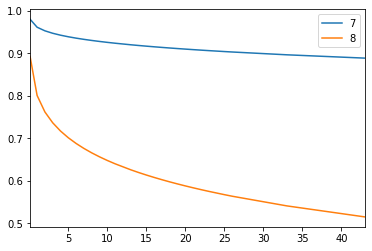

In [27]:
aft.predict_survival_function(nonCensored[['age']].iloc[7:9]).plot()

In [356]:
from lifelines import WeibullAFTFitter


aft = WeibullAFTFitter()
aft.fit(modelData, 'lastTime', event_col='primaryOutcome')   ## Fit the data to train the model
aft.print_summary(3)  # access the results using aft.summary

     fun: -1.6122431632688115
     jac: array([ 2.17905490e+03,  4.09032686e+02,  9.37119432e+02,  8.14220708e+02,
        1.28541327e+03,  2.91837457e+02,  4.03995064e+02,  1.11740383e+03,
        3.79925225e+03,  1.69616675e+03,  8.01604070e+02,  4.13079816e+03,
        2.71463967e+03,  2.10986334e+03,  3.30045065e+04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.13886637e+02,
        1.15115949e+02, -6.94212527e+02,  0.00000000e+00,  5.08193766e+02,
       -1.15974575e-01])
 message: 'Iteration limit exceeded'
    nfev: 405
     nit: 201
    njev: 201
  status: 9
 success: False
       x: array([-2.28478225e-07,  8.28417095e-06, -2.80861066e-06,  1.21889233e-05,
        1.79648640e-05,  5.28157927e-06,  6.43392608e-07,  7.59177222e-06,
        2.40177417e-05,  2.66959504e-05, -1.91142211e-05, -2.24654210e-05,
       -1.44602932e-06, -1.01223462e-05,  1.54287816e-06, -4.1627184

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column censored have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['primaryOutcome'].astype(bool)
>>> print(df.loc[events, 'censored'].var())
>>> print(df.loc[~events, 'censored'].var())

A very low variance means that the column censored completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/lifelines/utils/__init__.py:1150: ConvergenceWarning: Column time has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexch

ConvergenceError: Fitting did not converge. Try checking the following:

0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected?
2. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
3. Try using an alternate minimizer: ``fitter._scipy_fit_method = "SLSQP"``.
4. Trying adding a small penalizer (or changing it, if already present). Example: `WeibullAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.


In [357]:
modelData

,age,female,sofa,lymph,crp,dDimer,ferritin,hsTrop,hgb,lac,...,chronic_lung,home_o2,osa,immunocompromised,icu,primaryOutcome,lastTime,time,timeStandardized,censored
0,58.529,0,4.2,26.2,0.5,3.09,100.0,25.0,15.8,2.9,...,False,False,False,False,False,False,43.0,3.761200,0.491203,True
1,57.913,0,3.2,19.1,0.1,1.71,289.9,18.0,12.1,1.9,...,False,False,False,False,True,False,43.0,3.761200,0.491203,True
2,58.966,0,2.2,18.2,19.0,1.76,356.8,33.0,9.5,0.8,...,False,False,False,False,False,True,6.0,1.791759,-0.599897,False
3,52.980,0,1.2,2.2,31.6,1.28,1366.2,33.0,14.9,2.4,...,False,False,False,False,True,True,6.0,1.791759,-0.599897,False
4,59.241,0,0.2,7.1,6.4,0.82,946.0,14.0,12.6,0.8,...,False,False,False,False,False,False,43.0,3.761200,0.491203,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,67.510,1,3.2,6.0,13.9,40.00,146.1,98.0,11.4,1.9,...,False,False,False,False,True,True,43.0,3.761200,0.491203,False
320,52.008,0,2.2,7.0,32.6,1.25,1874.8,72.0,15.9,3.5,...,False,False,False,False,True,True,0.1,-2.302585,-2.868226,False
321,65.540,0,1.2,10.0,5.2,0.58,1694.4,15.0,17.5,3.4,...,False,False,False,False,True,False,17.0,2.833213,-0.022916,True
322,83.924,1,1.2,17.9,3.5,1.71,1271.1,22.0,13.1,1.6,...,False,False,False,False,True,False,17.0,2.833213,-0.022916,True


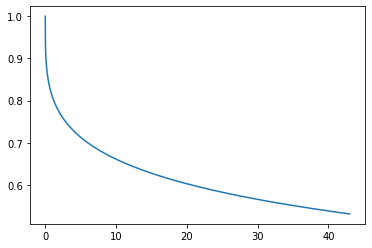

In [271]:
timeRange = np.linspace(0, 43, 10000)

age = 90
def getXb(age):
    return np.exp(15.954 + -0.118*age)

l = 1/getXb(age)

# sign of p is correct...
p = np.exp(-1.235)

# from https://data.princeton.edu/pop509/ParametricSurvival.pdf
def weibull_surv(l, p, t):
    return np.exp(-1*(l*t)**p)

survival = weibull_surv(l, p, timeRange)

plt.plot(timeRange, survival)

for t in timeRange:
    if weibull_surv(l, p, t) < 0.50:
        print(f"median survival: {t:0.2f}")
        break



In [317]:
aft.plot_covariate_groups('age', values=[41])

KeyError: 'covariate `age` is not present in the original dataset'

NameError: name 'age' is not defined